## Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import segyio
#np.set_printoptions(threshold=np.inf) # Print the entire dataframe
import holoviews as hv
from holoviews import opts, dim
from bokeh.models import HoverTool
hv.extension('bokeh')

ModuleNotFoundError: No module named 'pytest'

In [ ]:
np.set_printoptions(threshold=np.inf) # Print the entire dataframe

In [ ]:
#import hvplot.pandas
import panel as pn

In [ ]:
from scipy.interpolate import interp1d

In [ ]:
import datashader as ds

## Input data

In [ ]:
seismic_survey = 'POSEIDON 3D'
seismic_path = '../data/basemap_info (copia).txt'
wells_path = '../data/wells_info.txt'

# Validation function

In [ ]:
# collection of validation functions for seg-y pandas
def file_validation(file_path):
    
    """
    file_validation(file_path)
    
    Validates the input files.
    
    This functions validates the input data answering this questions:
    1) Does the file exist in the provided folder?
    2) Does the file has a .txt, .segy, -sgy extension?
    3) In case the input is a SEG-Y: is the file a standard SEG-Y?
    
    
    Argument
    --------
    file_path : str
        Path where the text or SEG-Y file to validate is located.
                 
    Return
    ------
    True : bool
        If the validations are True the output will be True, else a str.
    str
        If the validations (one at least) are False the output will be a Warning specifiying 
        why the function can't work with the given data.
        
        
    Notes
    -----
        This function compares the byte distribution of the given file and the ones used by segyIO. These 
        follows the Technical Standards Committee (2017) of the SEG.
    
    References
    ----------
    SEG Technical Standards Committee. (2017). SEG-Y_r2.0: SEG-Y revision 2.0 Data Exchange format.
        Document Online. Available at: 
        https://seg.org/Portals/0/SEG/News%20and%20Resources/Technical%20Standards/seg_y_rev2_0-mar2017.pdf

    """

    # First validation: does the file exist?
    if os.path.isfile(file_path):
        file, ext = os.path.splitext(file_path)
        
        # Second validation: does the file has a .txt, .sgy or .segy extension?
        if ext.lower() == (".txt") or ext.lower() == (".sgy") or ext.lower() == (".segy") :
            
            # Third validation: does the SEG-Y file is a standard SEG-Y data?
            if ext.lower() == (".sgy") or ext.lower() == (".segy"):
                with segyio.open(file_path,'r') as segyfile:
                    segyio_header = list(segyio.tracefield.keys.keys())
                    file_header = segyfile.header[0].keys()

                    # Comparing the trace header within the SEG-Y file with the ones in segyIO 
                    for i in range(0,len(segyfile.header[0].keys()),1):
                        if str(segyio_header[i]) == str(file_header[i]):

                            # If the list of headers is the same, return True
                            return(True)

                        # If the SEG-Y is not standard, return text: SEG-Y is not standard
                        else:
                            return(f"SEG-Y provided does not fulfill the requirements")

            # For both validation == True while not a SEG-Y, then return true
            else:
                return(True)
        
        # If not, return text: not a valid one
        else:
            return(f"The file extension in not valid.")
    
    # If not, return text: file does not exist
    else:
        return(f"The file given does not exist.")

In [ ]:
print(file_validation(seismic_path))
print(file_validation("whareveeeer"))
print(file_validation('../data/NS2950-2180_3000-2230.sgy'))

# Organizing the data

## wells data

In [ ]:
# wells dataframe
def wells_data_organization(wells_path):
    
    """
    wells_data_organization(wells_path)
    
    Builds a DataFrame using the well's information within the Seismic Survey.
    
    The function builds a (Pandas) DataFrame based on the information contained by the given text file
    related to wells. The data inside the file must be structured in a very specific way in order to be
    readen by the function. Each of the items listed below have to be separated by one space: 
        "well name" "utmx coordinate" "utmy coordinate" "inline coordinate" "xline coordinate" "depth"
    
    
    Argument
    --------
    wells_path : str
        Path where the well information file is located. Default path: '../data/wells_info.txt'
    
    Return
    ------
    well_dataframe : (Pandas) DataFrame. 
        A matrix compounded by the information related to each well. The information distribution is 
        controlled by the following columns:
            - name: well's name
            - cdp_iline: inline coordinate.
            - cdp_xline: crossline coordinate.
            - utmx: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utmy: vertical axis of the Universal Transversal Mercator coordinate system.
            - depth: depth reached by the well.
    
    str
        If the previous validations (one at least) are False the output will be a Warning specifiying 
        why the function can't work with the data.
        
    """   
     
    if file_validation(wells_path) == True:
    
        well_dataframe = pd.read_csv(wells_path,
                            sep=" ",
                            header = None, 
                            names= ["name","cdp_iline","cdp_xline","utmx","utmy", "depth"])
        
        well_dataframe["index"] = well_dataframe["name"]
        well_dataframe.set_index("index", inplace = True)
        
        return(well_dataframe)
    
    else:
        return(file_validation(wells_path))

In [ ]:
well_dataframe = wells_data_organization(wells_path)

## geometry data

In [ ]:
def cube_geometry_organization(seismic_txt):
    
    """
    cube_geometry_organization(seismic_txt)
    
    Builds a (Pandas) DataFrames given a text file with the geometry data.
    
    The function builds a (Pandas) DataFrame based on the information contained by the given text file
    related to a survey's geometry. The data inside the file must be structured in a very specific way 
    in order to be readen by the function: 
    - The first three rows must be the points of the survey. Use a tab as the separator of the items bellow
        "Name of the feature" "inline coordinate" "xline coordinate" "utmx coordinate" "utmy coordinate"
    - The last rows must be the geometry. Use a tab as the separator of the items bellow:
        "Name of the feature" "min" "max" "step"
    
    Arguments
    ---------
    seismic_txt : str
        Path where the text file is located.
    
    Return
    ------
    Dataframe_list : list of (Pandas)DataFrame
        Two matrix compounded by geometry parameters whose information is contained in the following columns:
        
        1) seismic_dataframe
            - feature: the parameter.
            - iline: inline coordinate.
            - xline: crossline coordinate.
            - utm_x: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utm_y: vertical axis of the Universal Transversal Mercator coordinate system.
        2) geometry_dataframe
            - feature: the parameter.
            - min: minimum value of the feature.
            - max: maximum value of the feature.
            - step: distance between two consecutive lines.
            
    str
        If the previous validations (one at least) are False the output will be a Warning specifiying 
        why the function can't work with the data.
        
    Note:
        We strongly recomend to follow the information distribution inside the "basemap_info.txt"
        located in the data folder so that the function can discriminate the rows to work with: 
            
            ###########################################################################
            #     feature    #   iline   #   xline   #      step      #  utmx #  utmy #
            ###########################################################################
            #edge_a          # iline     # xline     # blank          #  utmx #  utmy #
            #edge_b          # iline     # xline     # blank          #  utmx #  utmy #     
            #edge_c          # iline     # xline     # blank          #  utmx #  utmy #     
            #inline_range    # min_iline # max_iline # inline_step    # blank # blank #
            #crossline_range # min_xline # max_xline # crossline_step # blank # blank #
            ###########################################################################
            
    """
    
    if file_validation(wells_path) == True:
        
        dataframe = pd.read_csv(seismic_path,
                                sep = '\t',
                                header = None, 
                                names = ["feature","iline","xline","step","utmx","utmy"])
                                #index_col = "feature")
        
        # Splitting the data
        seismic_dataframe = dataframe.iloc[:3].dropna(axis = "columns")
        geometry_dataframe = dataframe.iloc[3:].dropna(axis = "columns")
        
        # Changing the columns name of the last df named
        geometry_dataframe.columns = ["feature", "min", "max", "step"]
        geometry_dataframe = geometry_dataframe.reset_index(drop=True)
            
        return([seismic_dataframe, geometry_dataframe])
    
    else:
        return(file_validation(wells_path))


In [12]:
# Calling the dataframes while dropping the NaN values
# PUEDO USAR ESTO EN OTRAS FUNCIONEEEEEEES
#cube_dataframe = cube_geometry_organization(seismic_path).iloc[:3].dropna(axis = "columns")
cube_dataframe = cube_geometry_organization(seismic_path)[0]
geometry_dataframe = cube_geometry_organization(seismic_path)[1]
geometry_dataframe

feature  min   max  step
0     inline_range  983  4419   1.0
1  crossline_range  504  5556   1.0

## Geometry data - Panel 

In [13]:
inst = pn.widgets.StaticText(name = "Introduce the corner's coordinates", value = "")
first_p = pn.widgets.StaticText(value = "First point")
a_x = pn.widgets.TextInput(value = "X coordinate")
a_y = pn.widgets.TextInput(value = "Y coordinate")
second_p = pn.widgets.StaticText(value = "Second point")
b_x = pn.widgets.TextInput(value = "X coordinate")
b_y = pn.widgets.TextInput(value = "Y coordinate")
third_p = pn.widgets.StaticText(value = "Third point")
c_x = pn.widgets.TextInput(value = "X coordinate")
c_y = pn.widgets.TextInput(value = "Y coordinate")
widgets = pn.WidgetBox('## Sea surface temperatures', inst,
                                                     first_p, a_x, a_y, 
                                                     second_p, b_x, b_y, 
                                                     third_p, c_x, c_y)
pn.Row(widgets).servable()

Row
    [0] WidgetBox(css_classes=['widget-box'])
        [0] Markdown(str)
        [1] StaticText(name="Introduce the c...)
        [2] StaticText(value='First point')
        [3] TextInput(value='X coordinate')
        [4] TextInput(value='Y coordinate')
        [5] StaticText(value='Second point')
        [6] TextInput(value='X coordinate')
        [7] TextInput(value='Y coordinate')
        [8] StaticText(value='Third point')
        [9] TextInput(value='X coordinate')
        [10] TextInput(value='Y coordinate')

In [14]:
a_x.value

'X coordinate'

# Basemap

## Computing the fourth edge of a data


In [15]:
def fourth_point_calc(dataframe):
    
    """
    fourth_point_calc(dataframe)
    
    Computes the fourh edge of a square or rectangle by given three of them.
    
    Arguments
    ---------
    dataframe : (Pandas)Dataframe
        Source of the points to use.
        
    Return
    ------
    fourth_edge_dataframe : (Pandas)Dataframe
        A matrix compounded by the information of the fourth edge of the polygon whose information 
        is contained in the following columns:
            - feature: the parameter.
            - iline: inline coordinate.
            - xline: crossline coordinate.
            - utm_x: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utm_y: vertical axis of the Universal Transversal Mercator coordinate system.  
            
    """
    
    # Initializing a list for the fourth edge's information
    edge_4 = ["edge_d"]
    
    # Point index
    first_point = dataframe[dataframe['feature'] == "edge_a"].index[0]
    second_point = dataframe[dataframe['feature'] == "edge_b"].index[0]
    third_point = dataframe[dataframe['feature'] == "edge_c"].index[0]
    
    # Variables 
    x1, y1 = dataframe["utmx"].iloc[first_point], dataframe["utmy"].iloc[first_point]
    x2, y2 = dataframe["utmx"].iloc[second_point], dataframe["utmy"].iloc[second_point]
    x3, y3 = dataframe["utmx"].iloc[third_point], dataframe["utmy"].iloc[third_point]
    i1, c1 = dataframe["iline"].iloc[first_point], dataframe["xline"].iloc[first_point]
    i2, c2 = dataframe["iline"].iloc[second_point], dataframe["xline"].iloc[second_point]
    i3, c3 = dataframe["iline"].iloc[third_point], dataframe["xline"].iloc[third_point]
    
    # Completing the esge_4's list  
    edge_4 = edge_4 + [i2 - i1 + i3, c2 - c1 + c3,x2 - x1 + x3, y2 - y1 + y3]
    
    # Making a dataframe to concatenate with the input
    fourth_edge_dataframe = pd.DataFrame([edge_4], columns = dataframe.keys())
    
    return(fourth_edge_dataframe)

In [16]:
fourth_point_calc(cube_dataframe)

feature  iline  xline       utmx        utmy
0  edge_d   4419   5556  409169.21  8537540.11

## Polygon building

In [17]:
def polygon_building(seismic_dataframe):

    """
    polygon_building(seismic_dataframe)
    
    Rebuilds the given dataframe by adding the remaining point to form the polygon of the seismic survey.
    
    Arguments
    ---------
    seismic_dataframe : (Pandas)Dataframe
        A matrix compounded by the three initial points that makes the seismic the survey polygon.
        
    Return
    ------
    seismic_dataframe : (Pandas)Dataframe
        A matrix compounded by all outter points of the seismic survey polygon.
  
    """
    if seismic_dataframe.shape[0] == 3:
        fourth_edge_dataframe = fourth_point_calc(seismic_dataframe)

        # Concatenating dataframes
        seismic_dataframe = pd.concat([seismic_dataframe, fourth_edge_dataframe], ignore_index = True)
        
    # Sorting the points
    utmx_min = seismic_dataframe.iloc[seismic_dataframe["utmx"].idxmin()]
    utmx_max = seismic_dataframe.iloc[seismic_dataframe["utmx"].idxmax()]
    utmy_min = seismic_dataframe.iloc[seismic_dataframe["utmy"].idxmin()]
    utmy_max = seismic_dataframe.iloc[seismic_dataframe["utmy"].idxmax()]
    
    # Rebuilding the given dataframe
    polygon_dataframe = pd.concat([utmx_min,utmy_min,utmx_max,utmy_max,utmx_min],
                                   ignore_index = True, axis="columns").transpose()
    

    return(polygon_dataframe)

In [18]:
polygon_dataframe = polygon_building(cube_dataframe)
polygon_dataframe

feature iline xline    utmx         utmy
0  edge_b   983  5556  367756  8.48819e+06
1  edge_a   983   504  416132  8.44759e+06
2  edge_c  4419   504  457545  8.49695e+06
3  edge_d  4419  5556  409169  8.53754e+06
4  edge_b   983  5556  367756  8.48819e+06

## Polygon Plot

In [19]:
def polygon_plot(seismic_dataframe):
    
    """
    polygon_plot(cube_dataframe)
    
    Plots the boundaries of the Seismic Survey using Holoview's bokeh backend.
    
    Arguments
    ---------
    seismic_dataframe : (Pandas) DataFrame. 
        A matrix compounded by the coordinates of the edge points of a survey.

    Return
    ------
    pol : Holviews element [Curve]
        Polygon that represents the boundaries of the Seismic Survey.
        
    See Also
    --------
    Plot functions:
        1) polygon_building(seismic_dataframe)
    
    """
    
    # Loading the polygon dataframe.
    polygon = polygon_building(seismic_dataframe)
    
    #Plotting the boundaries of the Seismic Survey. Holoviews Curve element
    pol = hv.Curve(polygon,"utmx","utmy", label = "Polygon")
    pol.opts(line_width=2, color="black", tools = ['pan','wheel_zoom','reset'], default_tools=[])
    
    return (pol)

In [20]:
polygon_plot(cube_dataframe)

:Curve   [utmx]   (utmy)

## Well plot

In [21]:
def wells_plot(seismic_dataframe, wells_dataframe):
    
    """
    wells_plot(cube_dataframe, wells_dataframe)
    
    Plots the wells inside the Seismic Survey polygon using Holoview's bokeh backend.
    
    The function plots only the wells inside the Seismic Survey given, therefore every well outside the this
    will be excluded from the final output.
    
    Arguments
    ---------
    cube_dataframe : (Pandas)DataFrame
        A matrix compounded by the trace header information of interest: coordinates of the 
        Seismic traces.
    
    wells_dataframe : (Pandas)DataFrame.
        A matrix formed by the information of each well inside the Seismic Survey.
    
    Return
    ------
    wells : Holviews element [Scatter]. 
        A plot of the wells inside the Seismic Survey.
    
    """
   
    # Plotting Wells. Holoviews Scatter element
    wells = hv.Scatter(wells_dataframe,["utmx","utmy"],
                       ["name","cdp_iline", "cdp_xline"], 
                       label = "Wells")
    wells.opts(line_width = 1,
               color = "green",size = 7 ,marker = "^",
               padding = 0.1, width=600, height=400, show_grid=True, 
               tools = ['pan','wheel_zoom','reset'], default_tools=[])
    
    # Adjusting the number of wells according to the outer polygon_building(cube_dataframe)
    l1 = seismic_dataframe["utmx"].loc[seismic_dataframe["utmx"].idxmin()]
    l2 = seismic_dataframe["utmx"].loc[seismic_dataframe["utmx"].idxmax()]
    l3 = seismic_dataframe["utmy"].loc[seismic_dataframe["utmy"].idxmin()]
    l4 = seismic_dataframe["utmy"].loc[seismic_dataframe["utmy"].idxmax()]
    
    return (wells[l1:l2,l3:l4])

In [22]:
wells_plot(cube_dataframe, well_dataframe)

:Scatter   [utmx,utmy]   (name,cdp_iline,cdp_xline)

## seismic_lines_dataframe

In [23]:
def seismic_lines_dataframe(geometry_dataframe, polygon_dataframe):
    
    """
    seismic_lines_dataframe(polygon_dataframe)
    
    Builds two dataframes that contains the coordinates of the points belonging to the first 
    inline and first crossline.
    
    Argument
    --------
    geometry_dataframe : (Pandas)Dataframe
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    polygon_dataframe : (Pandas)DataFrame
        A matrix that contains the coordinates of the four edges of the Survey.
    
    Return
    ------
    list_of_seismic_dataframes : (Pandas)DataFrame
        A list of two dataframes, where the first one contains all the coordinates of the points within
        the first crossline and the second one, all the coordinates of the points inside the first inline.

    """
    
    # Less stresful to read the code
    geo_df = geometry_dataframe
    df = polygon_dataframe
    
    # Feature index
    iline_range_index = geo_df[geo_df['feature'] == "inline_range"].index[0]
    xline_range_index = geo_df[geo_df['feature'] == "crossline_range"].index[0]
    
    # Computing the diference between min/max of the seismic lines
    dif_ilines = abs(geo_df["min"].iloc[iline_range_index] - geo_df["max"].iloc[iline_range_index]) + 1
    dif_xlines = abs(geo_df["min"].iloc[xline_range_index] - geo_df["max"].iloc[xline_range_index]) + 1
    
    # array of point's coordinates inside the first inline (based on dif_ilines)
    x_utmx = np.linspace(float(df[df["utmy"] == df["utmy"].min()]["utmx"]), 
                         df["utmx"].min(), 
                         num = dif_xlines, endpoint = True)

    x_utmy = np.linspace(df["utmy"].min(), 
                         float(df[df["utmx"] == df["utmx"].min()]["utmy"][0]), 
                         num = dif_xlines, endpoint = True)
    
    # Array of lines across the inline direction
    xlines = np.arange(geo_df["min"].iloc[xline_range_index], 
                       geo_df["max"].iloc[xline_range_index] + 1, 
                       1)
    
    # array of point's coordinates inside the first xline (based on dif_xlines)
    i_utmx = np.linspace(float(df[df["utmy"] == df["utmy"].min()]["utmx"]), 
                         df["utmx"].max(), 
                         num = dif_ilines, endpoint = True)

    i_utmy = np.linspace(df["utmy"].min(), 
                         float(df[df["utmx"] == df["utmx"].max()]["utmy"]), 
                         num = dif_ilines, endpoint = True)
    
    # Array of lines across the crossline direction
    ilines = np.arange(geo_df["min"].iloc[iline_range_index], 
                       geo_df["max"].iloc[iline_range_index] + 1,
                       1)
    
    # Making dataframes to ease further calculations
    xline_dataframe = pd.DataFrame({"iline": geo_df["min"].iloc[iline_range_index],
                                     "xline": xlines,
                                     "utmx": x_utmx, "utmy": x_utmy})
    iline_dataframe = pd.DataFrame({"iline": ilines,
                                     "xline": geo_df["min"].iloc[xline_range_index],
                                     "utmx": i_utmx, "utmy": i_utmy})

    return([iline_dataframe, xline_dataframe])

In [24]:
whatever = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[0]

## seismic_line_plot (included in seismic line plot)

In [25]:
def seismic_line_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number):
    
    """
    
    seismic_line_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number)
    
    Plots the seismic lines given set of inline and crossline coordinates using Holoview's bokeh backend.
    
    Arguments
    ---------
    geometry_dataframe : (Pandas)Datarame
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    polygon_dataframe : (Pandas)DataFrame
        A matrix that contains the coordinates of the four edges of the Survey.
        
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
        
    Return
    ------
    seismic_lines : Holviews element [Overlay]
        A collection seismic lines inside the survey.
    
    References
    ----------
        Change the attributes of the hover tool:
    https://bokeh.pydata.org/en/latest/docs/reference/models/tools.html#bokeh.models.tools.HoverTool.point_policy
    
    """

    # Assigning a variable for each dataframe in seismic_lines_dataframe
    ilines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[0]
    xlines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[1]
    
    # Declaring the Hover tools (each line will use one)
    iline_hover = HoverTool(tooltips=[("Inline", f"{iline_number}"),
                                      ("Utmx", "$x{(0.00)}"),
                                      ("Utmy", "$y{(0.00)}")])

    xline_hover = HoverTool(tooltips=[("Crossline", f"{xline_number}"),
                                      ("Utmx", "$x{(0.00)}"),
                                      ("Utmy", "$y{(0.00)}")])
    
    # Changing the attributes of the hover tool
    iline_hover.show_arrow, xline_hover.show_arrow = False, False
    iline_hover.point_policy, xline_hover.point_policy = "follow_mouse", "follow_mouse"
    iline_hover.anchor, xline_hover.anchor = "bottom_right", "bottom_right"
    iline_hover.attachment, xline_hover.attachment = "right", "right"
    iline_hover.line_policy, xline_hover.line_policy = "interp", "interp"
    
    # Computing the second point to plot the seismic lines (By using vector differences)
    ## This can be refactored
    iutmx = float(xlines["utmx"].iloc[-1] - xlines["utmx"].iloc[0] + ilines[ilines["iline"] == iline_number]["utmx"])
    iutmy = float(xlines["utmy"].iloc[-1] - xlines["utmy"].iloc[0] + ilines[ilines["iline"] == iline_number]["utmy"])
    xutmx = float(ilines["utmx"].iloc[-1] - ilines["utmx"].iloc[0] + xlines[xlines["xline"] == xline_number]["utmx"])
    xutmy = float(ilines["utmy"].iloc[-1] - ilines["utmy"].iloc[0] + xlines[xlines["xline"] == xline_number]["utmy"])

    # Plotting the Inline. Holoviews Curve element
    iline = hv.Curve([(float(ilines[ilines["iline"] == iline_number]["utmx"]), 
                        float(ilines[ilines["iline"] == iline_number]["utmy"])),
                       (iutmx, iutmy)])
    
    # Plotting the Crossline. Holoviews Curve element
    xline = hv.Curve([(float(xlines[xlines["xline"] == xline_number]["utmx"]), 
                        float(xlines[xlines["xline"] == xline_number]["utmy"])),
                       (xutmx, xutmy)])
    
    # Adding the hover tool in to the plots
    iline.opts(line_width = 2, color = "red", 
               tools = [iline_hover] + ['pan','wheel_zoom','reset'], default_tools=[])
    xline.opts(line_width = 2, color = "blue", 
               tools = [xline_hover] + ['pan','wheel_zoom','reset'], default_tools=[])
    
    # Making the overlay of the seismic plot to deploy
    seismic_lines = iline * xline
    
    return (seismic_lines)

In [26]:
seismic_line_plot(geometry_dataframe, polygon_dataframe, 1000, 520)

:Overlay
   .Curve.I  :Curve   [x]   (y)
   .Curve.II :Curve   [x]   (y)

## seismic_intersection

In [27]:
def seismic_intersection(geometry_dataframe, polygon_dataframe, iline_number, xline_number):
    """
    seismic_intersection(geometry_dataframe, polygon_dataframe, iline_number, xline_number)
    
    Computes the intersection of the seismic lines.
    
    Arguments
    ---------
    geometry_dataframe : (Pandas)Datarame
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    polygon_dataframe : (Pandas)DataFrame
        A matrix that contains the coordinates of the four edges of the Survey.
        
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
        
    Return
    ------
    trac_list : list
        A list of the information of the seismic intersection:
            - tracf: trace number within the original field record.
            - utmx: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utmy: vertical axis of the Universal Transversal Mercator coordinate system.  
     
    See also
    --------
        Seismic lines functions:
            1) seismic_lines_dataframe
            2) seismic_line_plot
    
    Formula
    -------
        To calculate the tracf given the geometry data:
        
            tracf = ΔLine(inline direction) * #CDP + ΔXline + 1
            
            where:
            - ΔLine(inline direction) is the amount of lines between the first inline and the given one.
            - #CDP the amount of CDP per crosslines.
            - ΔXline the difference between the given xline number and the first one.
            - +1 to count the first point (offten forgotten)
            
    """
    
    # Assigning a variable for each dataframe in seismic_lines_dataframe
    ilines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[0]
    xlines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[1]
    
    # less stressful to read
    geo_df = geometry_dataframe
    
    # Feature index
    iline_range_index = geo_df[geo_df['feature'] == "inline_range"].index[0]
    xline_range_index = geo_df[geo_df['feature'] == "crossline_range"].index[0]
    
    # Computing the amount of CDP along the crosslines 
    dif_xlines = abs(geo_df["max"].iloc[xline_range_index] - geo_df["min"].iloc[xline_range_index]) + 1
    
    # Tracf computation
    tracf_number = (iline_number - geo_df["min"][iline_range_index]) * dif_xlines + (xline_number - geo_df["min"][xline_range_index]) + 1
    
    # Tracf coordinates computation
    bx = float(xlines[xlines["xline"] == xline_number]["utmx"])
    by = float(xlines[xlines["xline"] == xline_number]["utmy"])
    ax = xlines["utmx"].iloc[0]
    ay = xlines["utmy"].iloc[0]
    cx = float(ilines[ilines["iline"] == iline_number]["utmx"])
    cy = float(ilines[ilines["iline"] == iline_number]["utmy"])
    
    tutmx = bx - ax + cx
    tutmy = by - ay + cy
    
    trac_list = [tracf_number, tutmx, tutmy]
    return (trac_list)

In [28]:
seismic_intersection(geometry_dataframe, polygon_dataframe, 1000, 520)

[85918, 416183.9152450878, 8447967.108746124]

## seismic_intersection_plot

In [29]:
def seismic_intersection_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number):
    
    """
    
    seismic_intersection_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number)
    
    Plots the intersection of the seismic lines using Holoview's bokeh backend.
    
    Arguments
    ---------
    geometry_dataframe : (Pandas)Datarame
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    polygon_dataframe : (Pandas)DataFrame
        A matrix that contains the coordinates of the four edges of the Survey.
        
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
        
    Return
    ------
    tracf_plot : Holviews element [Scatter]
        A plot of the interseccion of the seismic lines.
    
    """
    
    tracf_list = seismic_intersection(geometry_dataframe, polygon_dataframe, 
                                      iline_number, xline_number)
    
    # Declaring the Hover tools (each line will use one)
    tracf_hover = HoverTool(tooltips=[("Tracf", f"{tracf_list[0]}"),
                                      ("(I/X)", f"({iline_number}/{xline_number})"),
                                      ("(Utmx, Utmy)", "($x{(0.00)},$y{(0.00)}")])

    # Changing the attributes of the hover tool
    tracf_hover.show_arrow = False
    tracf_hover.point_policy = "follow_mouse"
    tracf_hover.anchor = "bottom_right"
    tracf_hover.attachment = "right"
    tracf_hover.line_policy = "interp"
    
    
    # Plot the intersection. Holovies Scatter element.
    tracf_plot = hv.Scatter((tracf_list[1], tracf_list[2]))
    tracf_plot.opts(size = 7, line_color = "black", line_width = 2, color = "yellow",
               tools = [tracf_hover] + ['pan','wheel_zoom','reset'], default_tools=[])
    
    return(tracf_plot)

## gather_box



In [30]:
def gather_box(geometry_dataframe, polygon_dataframe, iline_number, xline_number, 
                    number_of_gathers_to_display):
    """
    gather_box(geometry_dataframe, polygon_dataframe, iline_number, xline_number, number_of_gathers_to_display)
    
    Builds points (Pandas)Dataframes of the traces around the intesection of the given lines.
    
    This function calculates the tracf and the coordinates of the traces around the interseccion within
    a window which dimensions are equal to the square of the number_of_gathers_to_display arguement.
    
    Arguments
    ---------
    geometry_dataframe : (Pandas)Datarame
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    polygon_dataframe : (Pandas)DataFrame
        A matrix that contains the coordinates of the four edges of the Survey.
        
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
        
    number_of_gathers_to_display : int
        Number of points to be calculated, plot and displayed around the intersection of the seismic lines.
        
    Return
    ------
    [df, iline_gathers, xline_gathers] : list of (Pandas)Dataframe
        List of three matrix where df is the array with all the traces inside the box and 
        inline_gathers/xline_gathers are the dataframes whose points math the seismic lines given. Each 
        dataframe is compounded by the following columns:
            - tracf: trace number within the original field record.
            - utmx: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utmy: vertical axis of the Universal Transversal Mercator coordinate system. 
            - iline: inline coordinate.
            - xline: crossline coordinate.
    
    """
    
    # Less stressful to read
    nd = number_of_gathers_to_display
    
    # Tracf number and coordinates
    tracf = seismic_intersection(geometry_dataframe, polygon_dataframe, 
                                 iline_number, xline_number)
    
    # Points of the seismic lines
    ilines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[0]
    xlines = seismic_lines_dataframe(geometry_dataframe, polygon_dataframe)[1]
    
    # Feature index
    iline_range_index = geometry_dataframe[geometry_dataframe['feature'] == "inline_range"].index[0]
    xline_range_index = geometry_dataframe[geometry_dataframe['feature'] == "crossline_range"].index[0]
    
    # number_of_gathers_to_display = 2
    tracf_dataframe = pd.DataFrame(columns = {"tracf","utmx","utmy"})
    tracf_list = []
    
    # max min seismic lines
    iline_min = iline_number - nd//2 * geometry_dataframe["step"].iloc[iline_range_index]
    iline_max = iline_number + nd//2 * geometry_dataframe["step"].iloc[iline_range_index]
    xline_min = xline_number - nd//2 * geometry_dataframe["step"].iloc[xline_range_index]
    xline_max = xline_number + nd//2 * geometry_dataframe["step"].iloc[xline_range_index]

    # tracs around the intersection
    for inline in range(int(iline_min), int(iline_max) + 1, 1):
        for xline in range(int(xline_min), int(xline_max) + 1, 1):
            tracf_coordinates = seismic_intersection(geometry_dataframe, polygon_dataframe, inline, xline)
            
            tracf_list = tracf_list + [tracf_coordinates + [inline, xline]]
            
    df = pd.DataFrame(tracf_list, columns = ["tracf","utmx","utmy", "iline", "xline"])   
    
    # extracting the possible gathers along the seismic lines
    iline_gathers = df[(df.iline >= iline_min) &
                        (df.iline <= iline_max) & 
                        (df.xline == xline_number)]
    
    xline_gathers = df[(df.xline >= xline_min) &
                        (df.xline <= xline_max) & 
                        (df.iline == iline_number)]
    
    return([df, iline_gathers, xline_gathers])

In [31]:
something1 = gather_box(geometry_dataframe, polygon_dataframe, 2992, 
                        2203, 2)

# = gather_box(geometry_dataframe, polygon_dataframe, basemap[0][1].value, 
#                        basemap[0][2].value, basemap[0][3].value)
something1

[      tracf           utmx          utmy  iline  xline
 0  10148123  424074.553213  8.490080e+06   2991   2202
 1  10148124  424064.977639  8.490088e+06   2991   2203
 2  10148125  424055.402065  8.490096e+06   2991   2204
 3  10153176  424086.605827  8.490094e+06   2992   2202
 4  10153177  424077.030253  8.490102e+06   2992   2203
 5  10153178  424067.454679  8.490110e+06   2992   2204
 6  10158229  424098.658440  8.490108e+06   2993   2202
 7  10158230  424089.082866  8.490116e+06   2993   2203
 8  10158231  424079.507292  8.490124e+06   2993   2204,
       tracf           utmx          utmy  iline  xline
 1  10148124  424064.977639  8.490088e+06   2991   2203
 4  10153177  424077.030253  8.490102e+06   2992   2203
 7  10158230  424089.082866  8.490116e+06   2993   2203,
       tracf           utmx          utmy  iline  xline
 3  10153176  424086.605827  8.490094e+06   2992   2202
 4  10153177  424077.030253  8.490102e+06   2992   2203
 5  10153178  424067.454679  8.490110e+06   29

## Gather_box_plot

In [32]:
def gather_box_plot(gather_box_list):
    
    """
    gather_box_plot(gather_box_list)
    
    Plots the gather's window, intersection of the seismic lines and the traces around the last one within
    the first.
    
    Argument
    --------
    gather_box_list : llist of (Pandas)Dataframe
        List of three matrix where df is the array with all the traces inside the box and 
        inline_gathers/xline_gathers are the dataframes whose points math the seismic lines given.
    
    Return
    ------
    overlay : Holviews element [Overlay]
        A collection traces inside the gather window.
    
    """ 
    # Unboxing the list of the gathers points
    df = gather_box_list[0]
    iline_gathers = gather_box_list[1]
    xline_gathers = gather_box_list[2]
   
    # Making a polygon that contains the gathers
    polygon_gathers = polygon_building(df)
    
    # Setting hovers for the data
    hover = HoverTool(tooltips=[("I/X", f"@iline" + "/" + f"@xline"),
                                ("X/Y", "f@utmx" + "/" + f"@utmy"),
                                ("Trace number", f"@tracf")])

    # Changing the attributes of the hover tool
    hover.show_arrow = False
    hover.point_policy = "follow_mouse"
    hover.anchor = "bottom_right"
    hover.attachment = "right"
    hover.line_policy = "interp"
    
    # Plotting the position of the gathers
    plot_iline_gather = hv.Scatter(iline_gathers, ["utmx", "utmy"], ["tracf", "iline", "xline"]) 
    plot_iline_gather. opts(size = 5, line_color = "black", line_width = 2, color = "red",
                           tools = [hover] + ['pan','wheel_zoom','reset'], default_tools=[])
    plot_xline_gather = hv.Scatter(xline_gathers, ["utmx", "utmy"], ["tracf", "iline", "xline"])
    plot_xline_gather. opts(size = 5, line_color = "black", line_width = 2, color = "blue",
                           tools = [hover] + ['pan','wheel_zoom','reset'], default_tools=[])
    
    # Plotting the gather's cage
    polygon = hv.Curve(polygon_gathers, ["utmx","utmy"]).opts(line_width = 2, line_color = "black")
    points = hv.Scatter(polygon_gathers, ["utmx","utmy"]).opts(size = 10, color = "black")
    
    #Overlay
    overlay = polygon * points * plot_xline_gather * plot_iline_gather
    
    return(overlay)

In [33]:
gather = gather_box(geometry_dataframe, polygon_dataframe, 2992, 2203,2)
#gather = gather_box(geometry_dataframe, polygon_dataframe, basemap[0][1].value, basemap[0][2].value,2)
gather_box_plot(gather)

:Overlay
   .Curve.I     :Curve   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.I   :Scatter   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.II  :Scatter   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.III :Scatter   [utmx,utmy]   (tracf,iline,xline)

## How does the final overlay should look like

In [34]:
# theorically
iline_number = 3600
xline_number = 2000

# First element
seismic_polygon = polygon_plot(cube_dataframe)

# Second element
wells = wells_plot(cube_dataframe, well_dataframe)

# Third element
seismic_lines = seismic_line_plot(geometry_dataframe, polygon_dataframe, 
                                                      iline_number, xline_number)

# Fourth element
tracf = seismic_intersection_plot(geometry_dataframe, polygon_dataframe, 
                                  iline_number, xline_number)

# Fifth element
gather_b = gather_box(geometry_dataframe, polygon_dataframe, iline_number, xline_number,2)

gathers = gather_box_plot(gather_b)

# if the fourth one is plotted by the basemap, then WHY the fifth is rejected?

seismic_polygon * wells * tracf * seismic_lines * gathers

:Overlay
   .Curve.Polygon :Curve   [utmx]   (utmy)
   .Scatter.Wells :Scatter   [utmx,utmy]   (name,cdp_iline,cdp_xline)
   .Scatter.I     :Scatter   [x]   (y)
   .Curve.I       :Curve   [x]   (y)
   .Curve.II      :Curve   [x]   (y)
   .Curve.III     :Curve   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.II    :Scatter   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.III   :Scatter   [utmx,utmy]   (tracf,iline,xline)
   .Scatter.IV    :Scatter   [utmx,utmy]   (tracf,iline,xline)

## Basemap

In [35]:
def get_basemap(seismic_dataframe, geometry_dataframe, wells_dataframe, 
                min_iline_w, max_iline_w,
                min_xline_w, max_xline_w):
    
    """
    get_basemap(seismic_dataframe, geometry_dataframe, wells_dataframe, 
                min_iline, max_iline, min_xline, max_xline):
    
    Plots an interactive basemap for a given geometry and wells data.
    
    Arguments
    ---------
    seismic_dataframe : (Pandas)Dataframe
        A matrix compounded by the three initial points that makes the seismic the survey polygon.
        
    geometry_dataframe : (Pandas)Datarame
        A matrix compounded by the geometry parameters of the given Seismic Survey.
        
    wells_dataframe : (Pandas)DataFrame.
        A matrix formed by the information of each well inside the Seismic Survey.
        
    min_values : int
        Minimum value to control the slider widget. 
    
    max_values : int
        Maximum value to control the slider widget. 
           
    Return
    ------
    NdLayout : Panel layout element [Row]
        A Seismic Basemap and Panel's widgets listed as controls:
            - Two track bars to inspect the data by setting different inline and xline numbers.
            - A track bar to modify the amount of gathers displayed.
            - A select panel to choose the Well to inspect.
            
    [df, iline_gathers, xline_gathers] : list of (Pandas)Dataframe
        List of three matrix where df is the array with all the traces inside the box and 
        inline_gathers/xline_gathers are the dataframes whose points math the seismic lines given. Each 
        dataframe is compounded by the following columns:
            - tracf: trace number within the original field record.
            - utmx: horizontal axis of the Universal Transversal Mercator coordinate system.
            - utmy: vertical axis of the Universal Transversal Mercator coordinate system. 
            - iline: inline coordinate.
            - xline: crossline coordinate.
    
    See also
    --------
        Plot functions:
            1) polygon_plot(cube_dataframe)
            2) wells_plot(cube_dataframe, wells_dataframe)
            3) seismic_line_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number)
            4) seismic_intersection_plot(geometry_dataframe, polygon_dataframe, iline_number, xline_number)
            5) gather_box_plot(gather_box_list)
    
    Notes
    -----
     Setting the start/end/value of the Sliders ended giving an error that points another error in the
     previous functions, therefore as long as a we don't find a proper way to include these limits, they
     will be put as the argument's function.
     
     Se second output (the list) will be used further in the wiggle.py module.

    """
    
    
    # Widgets
    iline_number = pn.widgets.IntSlider(name = "Inline number",
                                        start = min_iline_w,
                                        end = max_iline_w,
                                        step = 1,
                                        value = min_iline_w)
    
    xline_number = pn.widgets.IntSlider(name = "Crossline number",
                                        start = min_xline_w,
                                        end = max_xline_w,
                                        step = 1,
                                        value = min_xline_w)
    
    gather_display = pn.widgets.IntSlider(name = "Number of gathers to display",
                                          start = 2,
                                          end = 6,
                                          step = 2,
                                          value = 2)
    
    select_well = pn.widgets.Select(name = "Select the well to inspect", 
                                    options = ["None"] + list(well_dataframe["name"]),
                                    value = "None")
    
    @pn.depends(iline_number.param.value, xline_number.param.value, 
                gather_display.param.value, 
                select_well.param.value)
    
    def basemap_plot(iline_number, xline_number, gather_display, select_well):
        
        if select_well !=  "None":
            iline_number = int(well_dataframe[well_dataframe["name"] == select_well]["cdp_iline"])
            xline_number = int(well_dataframe[well_dataframe["name"] == select_well]["cdp_xline"])
        
        # First element
        seismic_polygon = polygon_plot(seismic_dataframe)

        # Second element
        wells = wells_plot(seismic_dataframe, wells_dataframe)
        
        # Third element
        seismic_lines = seismic_line_plot(geometry_dataframe, polygon_dataframe, 
                                          iline_number, xline_number)

        # Fourth element
        gather = gather_box(geometry_dataframe, polygon_dataframe, 
                            iline_number, xline_number, gather_display)
        
        gathers = gather_box_plot(gather)

        # Fifth element dataframe
        tracf = seismic_intersection_plot(geometry_dataframe, polygon_dataframe, 
                                          iline_number, xline_number) 
     
        # Final Overlay
        basemap = seismic_polygon * wells * seismic_lines * gathers * tracf

        return(basemap)
    
    widgets = pn.WidgetBox(f"## {seismic_survey} Basemap", iline_number, xline_number, 
                                          gather_display, select_well)
    
    return (pn.Row(widgets, basemap_plot).servable())

In [36]:
basemap = get_basemap(cube_dataframe, geometry_dataframe, well_dataframe, 1000,4000, 1000, 4000)
basemap

Row
    [0] WidgetBox(css_classes=['widget-box'])
        [0] Markdown(str)
        [1] IntSlider(end=4000, name='Inline number', start=1000, value=1000)
        [2] IntSlider(end=4000, name='Crossline number', start=1000, value=1000)
        [3] IntSlider(end=6, name='Number of gathers t..., start=2, step=2, value=2)
        [4] Select(options=['None', 'Boreas_1', ...], value='None')
    [1] ParamFunction(function)

# Wiggle plot

### Inputs

In [53]:
# Initialazing the gathers
s_path = os.path.join("..", "data", "NS2950-2180_3000-2230.sgy")
s_path1 = os.path.join("..", "data", "MS2950-2180_3000-2230.sgy")
s_path2 = os.path.join("..", "data", "FS2950-2180_3000-2230.sgy")

# Do a list of gathers
gather_path = [s_path, s_path1, s_path2]

# To build a generic gather list to use as argument for the next functions
first_angle = 12
last_angle = 36
angle_bet_gathers = 12
angle_list = []
for angle in range(first_angle, last_angle + 1, angle_bet_gathers):
    angle_list = angle_list + [angle]

### Merging with SEGYIO

In [54]:
# def seg_merg(list_of_gathers, list_of_angles)

# New path
new_segy = os.path.join("..", "data", "SEGY_MERGE.sgy")
# Assigning values to the spec function to create the new segy. Copying the geometry
with segyio.open(s_path) as segy, segyio.open(s_path1) as segy1, segyio.open(s_path2) as segy2:
    spec = segyio.spec()
    spec.sorting = segy.sorting
    spec.format = segy.format
    spec.samples = segy.samples
    spec.ilines = segy.ilines
    spec.xlines = segy.xlines
    spec.offsets[:] = np.array(angle_list)
    
    # Copying the headers
    with segyio.create(new_segy, spec) as nsegy:
            nsegy.text[0] = segy.text[0]
            nsegy.bin = segy.bin
            nsegy.header = segy.header
            nsegy.header.offset = np.array(angle_list)
            nsegy.iline[:,12] = segy.iline[:]
            nsegy.iline[:,24] = segy1.iline[:]
            nsegy.iline[:,36] = segy2.iline[:]
            print(nsegy.iline[2950,12][0][750], nsegy.iline[2950,24][0][750], nsegy.iline[2950,36][0][750])
            print(segy.trace[0][750], segy1.trace[0][750], segy2.trace[0][750])
            print(nsegy.gather[2950,2180,24][750])
            print(nsegy.offsets)


18.0 8.0 0.0
18.0 8.0 0.0
8.0
[12 24 36]


## List of min/max seismic lines to plot controlled by the button widget 

In [55]:
def min_max_seismic_lines(df, button, iline_number, xline_number, 
                          number_of_gathers_to_display):
    
    """
    
    min_max_seismic_lines(df, button, iline_number, xline_number, number_of_gathers_to_display)

    Makes a list of seismic lines (min/max coordinates) to be use as the argument of segyIO's GATHER 
    function.
    
    Arguments
    ---------
    df : (Pandas) DataFrame
        A matrix compounded by the trace header information of interest: coordinates of the 
        Seismic traces.
    
    button : str
        Seismic direction used to read and plot the information related to the gathers. The value comes 
        from Panel's select widget: RadioButtonGroup located in the get_wiggle function. 
        Default value: "Inline".
    
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
        
    number_of_gathers_to_display : int
        The amount of gathers to display along with the main given point which is the intersection of 
        the iline_number and xline_number. Default value = 2.
        
    Return
    ------
    list_of_seismic_coordinates : list
        A list compounded by the minimum and maximum values of the seismic lines coordinates to be 
        used by segyIO's GATHER function to extract the amplitude array from the SEG-Y file.

    Note1:
        The segyIO's GATHER function uses as its argument the inline and crossline coordinates to 
        store/extract the amplitudes with the SEG-Y file. The intersection of these lines results in 
        the TRACF header.
    
    """ 
    
    if button == "Inline":
        iline_step = 0
        xline_step = 1
        xline_min = xline_number - xline_step * number_of_gathers_to_display // 2
        xline_max = xline_number + xline_step * number_of_gathers_to_display // 2   
        
        # Solving boundaries issues for inline direction
        if xline_min < df['xline'].min():
            xline_max = xline_max + abs(xline_min - df['xline'].min())
            return[iline_number, iline_number, df['xline'].min(), xline_max]
        
        if xline_max > df['xline'].max():
            xline_min = xline_min - abs(xline_max - df['xline'].max()) 
            return[iline_number, iline_number, xline_min, df['xline'].max()]
        
        else:
            return[iline_number, iline_number, xline_min, xline_max]
        
    
    else:
        iline_step = 1
        xline_step = 0
        iline_min = iline_number - iline_step * number_of_gathers_to_display // 2
        iline_max = iline_number + iline_step * number_of_gathers_to_display // 2 
         
        # Solving boundaries issues for crossline direction    
        if iline_min < df['iline'].min():
            iline_max = iline_max + abs(iline_min - df['iline'].min())
            return[df['iline'].min(), iline_max, xline_number, xline_number]
        
        if iline_max > df['iline'].max():
            iline_min = iline_min - abs(iline_max - df['iline'].max()) 
            return[iline_min, df['iline'].max(), xline_number, xline_number]
        
        else:     
            return[iline_min, iline_max, xline_number, xline_number]

In [56]:
gather_b = gather_box(geometry_dataframe, polygon_dataframe, basemap[0][1].value, 
                        basemap[0][2].value, basemap[0][3].value)

boundary = min_max_seismic_lines(gather_b[0], "Inline", 
                                 basemap[0][1].value, basemap[0][2].value, 
                                 basemap[0][3].value)


## Computing the scaling factor for the x axis

In [70]:

    
scaling_fac = 0
with segyio.open(new_segy,'r') as segy:
    print(segy.iline)

ValueError: Inlines inconsistent, expect all inlines to be unique

In [62]:
def scaling_fact(list_of_gathers):
    
    """
    scaling_fact(list_of_gathers)
    
    Computes the maximum absolute value of the amplitudes within the SEG-Y files.
    
    Argument
    --------
    list_of_gathers : list
        A list compounded by the path of each partial angle stack file to be used.
        
    Return
    ------
    scaling_fac : float
        Value to be used to scale the axis related to the amplitudes, therefore these will bounded 
        between [-1,1].

    """
    
    scaling_fac = 0
    for file in list_of_gathers:
        with segyio.open(file,'r') as segy:
            something = abs(segyio.tools.collect(segy.trace[:]))   
            if something.max() > scaling_fac:
                scaling_fac = something.max()
                
    return (float(scaling_fac))

In [59]:
scaling_fact(gather_path)

127.0

## Computing time axis
Partial angle stacks files share the same geometry, therefore in order to compute those parameters we will only use one of them.

In [43]:
def time_axis(one_gather_file):
    
    """
    
    time_axis(one_gather_file)
    
    Builds the time axis of the plot based on the sample interval and the number of samples
    per trace stored within the SEG-Y file.
    
    Argument
    --------
    one_gather_file : str
        Path of a partial angle stack file to extract the information inside the trace headers.
        
    Return
    ------
    time_array : np.array
        An array compounded by the time samples of each trace in the SEG-Y file.
        
    Note:
        Partial angle stacks shares geometry, therefore only one is needed to calculate the vertical 
        axis of the plot.
    
    """
    
    # Every trace has the same sample interval so as the samples per trace
    first_trace = 0
    with segyio.open(one_gather_file,'r') as segy:     
        # Extracting the sample interval and the amount of amplitudes from the header. Also us to s
        sample_interval = float(segy.attributes(segyio.TraceField.TRACE_SAMPLE_INTERVAL)[first_trace]/1000000)
        samples_per_trace = int(segy.attributes(segyio.TraceField.TRACE_SAMPLE_COUNT)[first_trace])
        
        time_array = np.arange(first_trace,sample_interval * samples_per_trace,sample_interval)
        
    return (time_array)

In [44]:
time_axis(seismic_path)[1]

0.004

## Spline interpolation

In [45]:
def spline_storepolation (iline_number, xline_number, list_of_gathers, time_interval, 
                          angle_bet_gathers):
    
    """
    spline_storepolation (iline_number, xline_number, list_of_gathers, time_interval)
    
    Makes and stores (Pandas DataFrame) a spline interpolation of amplitudes and time samples for
    a given interval.
    
    This function is used to smooth the wiggle plot: the sampling inside the SEG-Y files is not good 
    enough to recreate the shape of a zero phase wavelet, hence this function approximates the data to 
    a seismic wavelet and not to a sismological wave.
    
    Arguments
    ---------
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    list_of_gathers : list
        A list compounded by the path of each partial angle stack file to be used.
        
    time_array : np.array
        An array compounded by the time samples of each trace in the SEG-Y file. Y axis of the plot.

    angle_bet_gathers : int
        The reason of the media of each gather.
        
    Return
    ------
    amp_dataframe : (Pandas) DataFrame
        A matrix made of amplitude arrays for each angle gather loaded.
        
    Note:
        The amplitude array has been separated in two series: positive_amplitude and negative_amplitude 
        for each angle loaded. These will be used along with the Holoviews Area element in order to 
        apply the usual polarity displayed in gathers. The result of the previous element simulates 
        matplotlib's fill_in_between function using bokeh.
    
    """
    
    # Initializing the dataframe and angle
    amp_dataframe = pd.DataFrame([])
    angle = angle_bet_gathers
    
    # Making the Y axis
    t_axis = time_axis(list_of_gathers[0])
    
    #Interpolate to:
    new_time = np.arange(t_axis[0],t_axis[-1] + time_interval, time_interval)
    
    amp_dataframe["time_axis"] = new_time
    amp_dataframe["iline"] = iline_number
    amp_dataframe["xline"] = xline_number
    
    # Extracting the amplitude array from the SEG-Y file
    for file in list_of_gathers:
        with segyio.open(file,'r') as segy:
            amp = segy.gather[iline_number, xline_number][0] # [0] because is an ndarray of a ndarray

        # Spline interpolation
        f_spline = interp1d(t_axis, amp, kind = "cubic")
        new_amp = f_spline(new_time)
    
        # Making two more series: Negative amplitude and positive amplitude
        amp_dataframe[f"amplitude_{angle}"] = new_amp
        amp_dataframe[f"positive_amplitude_{angle}"] = new_amp
        amp_dataframe[f"negative_amplitude_{angle}"] = new_amp
        
        # Separating the values of the amplitudes for Area element
        amp_dataframe.loc[amp_dataframe[f"positive_amplitude_{angle}"] < 0 , f"positive_amplitude_{angle}"] = 0
        amp_dataframe.loc[amp_dataframe[f"negative_amplitude_{angle}"] > 0 , f"negative_amplitude_{angle}"] = 0
        
        # Taking control of the angle related to the amplitude to store it in a dataframe
        angle = angle + angle_bet_gathers
            
    return (amp_dataframe.round(4))  

In [46]:
amp_dataframe = spline_storepolation(basemap[0][1].value, basemap[0][2].value, 
                                     gather_path, 0.0004, 12)
amp_dataframe.head()

time_axis  iline  xline  amplitude_12  positive_amplitude_12  \
0     0.0000   2997   2202           0.0                    0.0   
1     0.0004   2997   2202          -0.0                    0.0   
2     0.0008   2997   2202          -0.0                    0.0   
3     0.0012   2997   2202          -0.0                    0.0   
4     0.0016   2997   2202          -0.0                    0.0   

   negative_amplitude_12  amplitude_24  positive_amplitude_24  \
0                    0.0           0.0                    0.0   
1                   -0.0          -0.0                    0.0   
2                   -0.0          -0.0                    0.0   
3                   -0.0          -0.0                    0.0   
4                   -0.0          -0.0                    0.0   

   negative_amplitude_24  amplitude_36  positive_amplitude_36  \
0                    0.0           0.0                    0.0   
1                   -0.0          -0.0                    0.0   
2                   -0.0          -0.0                    0.0   
3                   -0.0          -0.0                    0.0   
4                   -0.0          -0.0                    0.0   

   negative_amplitude_36  
0                    0.0  
1                   -0.0  
2                   -0.0  
3                   -0.0  
4                   -0.0

## Wiggle plot

In [47]:
def wiggle_plot(amp_df, iline_number, xline_number, list_of_gathers, time_slice_top, angle_bet_gathers):
    
    """
    wiggle_plot (df, list_of_gathers, iline_number, xline_number, time_slice_top)
    
    Plots the amplitude matrix into the shape of a zero phase wavelet.
    
    Arguments
    ---------
    amp_df : (Pandas) DataFrame
        A matrix compounded by the trace header information of interest: coordinates of the 
        Seismic traces.
    
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    list_of_gathers : list
        A list compounded by the path of each partial angle stack file to be used.
    
    time_slice_top : int
        A value that controls the top of the Y axis (time) displayed. The value comes from Panel's slider
        widget inside get_widget function of the wiggle module.
    
    Return
    ------
    wiggle_display : Holviews element [Overlay]
        A collection zero phase wavelets of the given partial angle stacks and inline/crossline.
    
    
    Note:
        The plot combines the Curve and Area elements, both of Holoviews. The first one is responsible 
        of ensuring the layout of the seismic zero fase wavelet of a gather and the deployment of the 
        information through a hover tool. The second one is responsible of showing the amplitudes 
        polarity along the time axis, where:
            - Positive values = Blue
            - Negative values = Red
            - Null values (0) = Black
    
    """
    
    # Initializing the plot and the angle variable
    wiggle_display = hv.Curve((0,0))
    angle = angle_bet_gathers

    # Computing scale factor for the X axis
    scale_f = scaling_fact(list_of_gathers)
    s_factor = 0
    xticks = [] 
    
    # making the data to plot according a scaled value
    for file in list_of_gathers:
        
        amp_df[f"s_amplitude_{angle}"] = amp_df[f"amplitude_{angle}"] + s_factor
        amp_df[f"s_negative_amplitude_{angle}"] = amp_df[f"negative_amplitude_{angle}"] + s_factor
        amp_df[f"s_positive_amplitude_{angle}"] = amp_df[f"positive_amplitude_{angle}"] + s_factor
        
        # Hover designation
        hover_w= HoverTool(tooltips=[('Time', '@time_axis'),
                                     ('Amplitude', f"@amplitude_{angle}"),
                                     ("Angle",f"{angle}")])  
         
        # Plotting the wiggle
        wiggle = hv.Curve(amp_df, ["time_axis", f"s_amplitude_{angle}"], 
                              [f"amplitude_{angle}"])
        wiggle.opts(color = "black", line_width = 2, tools = [hover_w])
          
        # Making the area plot more comfortable
        x = amp_df["time_axis"]
        y = s_factor
        y2 = amp_df[f"s_negative_amplitude_{angle}"]
        y3 = amp_df[f"s_positive_amplitude_{angle}"]
        
        # Fill in between: Holoviews Element
        negative = hv.Area((x, y, y2), vdims=['y', 'y2']).opts(color = "red", line_width = 0)
        positive = hv.Area((x, y, y3), vdims=['y', 'y3']).opts(color = "blue", line_width = 0)        
        fill_in_between = negative * positive
        
        # Overlying the colored areas +  the zero phase wavelet
        wiggle_display = wiggle_display * wiggle * fill_in_between
        
        # For next iteration
        xticks = xticks + [(s_factor, angle)]
        angle = angle + angle_bet_gathers
        s_factor = s_factor + scale_f
        
        # Adding final customizations
        wiggle_display.opts(height = 500, width = 150, padding = 0.1,
                            show_grid = True, xaxis = "top", invert_axes = True, invert_yaxis=True,
                            fontsize={"title": 10, "labels": 14, "xticks": 8, "yticks": 8},
                            ylabel = f"{iline_number}/{xline_number}", xlabel = "Time [s]",
                            xformatter = "%f", yformatter = "%.1f", xticks = xticks,
                            xlim = (time_slice_top, time_slice_top + 1),
                            active_tools = ["pan", "wheel_zoom"])
        
    return(wiggle_display)

In [48]:
wiggle_plot(amp_dataframe, basemap[0][1].value, basemap[0][2].value, gather_path, 4, angle_bet_gathers)

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [time_axis,s_amplitude_12]   (amplitude_12)
   .Area.I    :Area   [x]   (y,y2)
   .Area.II   :Area   [x]   (y,y3)
   .Curve.III :Curve   [time_axis,s_amplitude_24]   (amplitude_24)
   .Area.III  :Area   [x]   (y,y2)
   .Area.IV   :Area   [x]   (y,y3)
   .Curve.IV  :Curve   [time_axis,s_amplitude_36]   (amplitude_36)
   .Area.V    :Area   [x]   (y,y2)
   .Area.VI   :Area   [x]   (y,y3)

## Wiggle display

In [49]:
def get_wiggle(df, iline_number, xline_number, list_of_gathers, angle_bet_gathers, gathers_to_display):
    
    """
    get_wiggle(df, iline_number, xline_number, list_of_gathers)
    
    Plots an interactive gather for a given partial angle stacks and inline/crossline coordinates.
    
    Arguments
    ---------
    df : (Pandas) DataFrame
        A matrix compounded by the trace header information of interest: coordinates of the 
        Seismic traces.
    
    iline_number : int
        Number of the seismic line along the inline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    xline_number : int
        Number of the seismic line along the crossline direction. The value could be given manually
        or by Panel's slider widget inside the get_basemap function of the basemap module.
    
    list_of_gathers : list
        A list compounded by the path of each partial angle stack file to be used.

    angle_bet_gathers : int
        The reason of the media of each gather.
    
    Return
    ------
    NdLayout : Panel layout element [Row]
        A collection of gathers and Panel's widgets listed as controls:
            - A track bar to modify the amount of gathers displayed.
            - A button to change the between the seismic directions: Inline or Crossline.
            - Two track bars to make time slices (at least by one second).
            - A track bar to change the sample interval used by the spline_storepolation function.
            
    See also
    --------
        wiggle plot functions:
            1) min_max_seismic_lines(df, button, iline_number, xline_number, number_of_gathers_to_display)
            2) scaling_fact(list_of_gathers)
            3) time_axis(one_gather_file)
            4) spline_storepolation (iline_number, xline_number, list_of_gathers, time_interval)
            5) wiggle_plot(df, iline_number, xline_number, list_of_gathers, time_slice_top)

    """
    
    # Display
    display_iline_number = pn.widgets.StaticText(name = 'Selected Inline', value = str(iline_number))
    
    display_xline_number = pn.widgets.StaticText(name = 'Selected Crossline', value = str(xline_number))
    
    gather_direction = pn.widgets.StaticText(value = " Direction to plot the gathers")
    
    display_controls = pn.widgets.StaticText(value = "Display controls")
    
    # Buttons
    seismic_buttons = pn.widgets.RadioButtonGroup(name='Radio Button Group', 
                                                  options=['Inline', 'Crossline'], button_type='success')
    
    
    # Sliders
    time_slice_top = pn.widgets.IntSlider(name = "Survey's top [s]", 
                                          start = int(time_axis(list_of_gathers[0])[0]), 
                                          end = int(time_axis(list_of_gathers[0])[-1] - 1), 
                                          step = 1, 
                                          value = 0)
    time_slice_base = pn.widgets.IntSlider(name = "Survey's base [s]", 
                                           start = int(time_axis(list_of_gathers[0])[0] + 1), 
                                           end = int(time_axis(list_of_gathers[0])[-1]), 
                                           step = 1, 
                                           value = 6)
    
    sample_interval = pn.widgets.FloatSlider(name = "Sample interval [s]", 
                                            start = 0.001, 
                                            end = 0.004, 
                                            step = 0.001, 
                                            value = 0.004)
    
    number_gather_display = pn.widgets.IntSlider(name = "Extra gathers to display", 
                                                 start = 2, 
                                                 end = 6, 
                                                 step = 2, 
                                                 value = 2)
       
    # Decorator to mess up with the API
    @pn.depends(time_slice_top.param.value, time_slice_base.param.value,
                sample_interval.param.value,seismic_buttons.param.value, number_gather_display.param.value)
    
    def gather_plot(time_slice_top, time_slice_base, sample_interval ,seismic_buttons, number_gather_display):
        
        scale_factor = scaling_fact(list_of_gathers)
        s_f = 0

        # Initializing dictionary for holoviews layout element
        angle_gather_dict = {}
        
        max_min_gathers = min_max_seismic_lines(df, seismic_buttons, iline_number, xline_number, 
                                                gathers_to_display)
        
        for inline in range(max_min_gathers[0], max_min_gathers[1] + 1, 1):
            for crossline in range(max_min_gathers[2], max_min_gathers[3] + 1, 1):

        # Making the dataframe
                amp_dataframe = spline_storepolation(inline, crossline, 
                                                     list_of_gathers, sample_interval, angle_bet_gathers)

        # Cropping the dataframe according to the time_variant variable. when t_w = 0, no crop is done
                amp_dataframe = amp_dataframe[(amp_dataframe.time_axis >= time_slice_top) &
                                              (amp_dataframe.time_axis <= time_slice_base)]

                # Plotting the wiggle from the top chosen with the slider to the previous + 1
                gather = wiggle_plot (amp_dataframe, inline, crossline, list_of_gathers, 
                                      time_slice_top, angle_bet_gathers)

                # Changing some parameters of the plot: y axis label + y axis line
                if (inline == max_min_gathers[0]) and (crossline == max_min_gathers[2]):
                    gather.opts(xlabel = "Time [s]", width = 200)
                else:
                    gather.opts(xlabel = " ", yaxis = None, width = 150)
                    
                angle_gather_dict[f"{inline}/{crossline}"] = gather

            # NdLayout for the dictionary
        NdLayout = hv.NdLayout(angle_gather_dict, kdims = f"Angle Gather (I/X)")
        return(NdLayout)
    
    widgets = pn.WidgetBox(f"## Gathers display Panel", display_iline_number,
                                                             display_xline_number, 
                                                             pn.Spacer(height = 10),
                                                             number_gather_display,
                                                             pn.Spacer(height = 10),
                                                             gather_direction,
                                                             seismic_buttons,
                                                             pn.Spacer(height = 10),
                                                             display_controls,
                                                             time_slice_top,
                                                             time_slice_base,
                                                             sample_interval)
                        
    return((pn.Row(widgets, gather_plot).servable()))

In [50]:
gathers = get_wiggle(gather_b[0], 
                     basemap[0][1].value, basemap[0][2].value,
                     gather_path, angle_bet_gathers, basemap[0][3].value)
gathers

Row
    [0] WidgetBox(css_classes=['widget-box'])
        [0] Markdown(str)
        [1] StaticText(name='Selected Inline', value='2997')
        [2] StaticText(name='Selected Crossline', value='2202')
        [3] Spacer(height=10)
        [4] IntSlider(end=6, name='Extra gathers t..., start=2, step=2, value=2)
        [5] Spacer(height=10)
        [6] StaticText(value=' Direction to p...)
        [7] RadioButtonGroup(button_type='success', name='Radio Button Group', options=['Inline', 'Crossline'], value='Inline')
        [8] Spacer(height=10)
        [9] StaticText(value='Display controls')
        [10] IntSlider(end=5, name="Survey's top [s]")
        [11] IntSlider(end=6, name="Survey's base [s]", start=1, value=6)
        [12] FloatSlider(end=0.004, name='Sample interval [s]', start=0.001, step=0.001, value=0.004)
    [1] ParamFunction(function)

# AVO.py

## Making the amplitude dataframe - Pandas

In [51]:
# angle amplitude dataframe
def amplitude_array(polygon_dataframe, angle_between_gathers, list_of_gathers, list_of_angles):

    # Initializing elements
    angle_list = []
    avo_dataframe = pd.DataFrame([])
    angle = angle_between_gathers

    # Making the amplitude array by extracting the values from file with spline_storepolation 
    min_iline = 2950 #polygon_dataframe["iline"].min()
    max_iline = 2970 #polygon_dataframe["iline"].max()
    min_xline = 2180 #polygon_dataframe["xline"].min()
    max_xline = 2200 #polygon_dataframe["xline"].max()
    
    for i in range(min_iline, max_iline + 1):
        for j in range(min_xline, max_xline + 1):
            avo = spline_storepolation(i,j, list_of_gathers, 0.004, angle_between_gathers)

            # Dropping the positive and negative columns of the spline_storepolation's output
            for angle in list_of_angles:
                avo = avo.drop([f"positive_amplitude_{angle}", f"negative_amplitude_{angle}"], axis = 1)

            # concat
            avo_dataframe = pd.concat([avo, avo_dataframe], ignore_index = True)
        
    return (avo_dataframe)
    
        
#gather_b[0]

In [52]:
avo_dataframe = amplitude_array(polygon_dataframe, angle_bet_gathers, gather_path,[12,24,36])
avo_dataframe.drop(avo_dataframe.columns[[3, 4, 5]], axis=1)
#41s

KeyboardInterrupt: 

## Making the amplitude dataframe - dask

## Computing AVO attributes - Linear regression - Solving the Avset equation

In [ ]:
def ig_computation(amplitude_dataframe, list_of_angles):
    gradient_list = []
    intercept_list = []
    c_list = []
    # First matrix: A
    a_list = []
    for angles in list_of_angles:
        row = [1, np.sin(angles * np.pi/180)**2]
        a_list = a_list + [row]
    a = np.array(a_list)
    at = np.transpose(a)

    for index in range(len(amplitude_dataframe)):
        # Second matrix: B
        b_list = []

        for angles in list_of_angles:
            row = [amplitude_dataframe[f"amplitude_{angles}"].iloc[index]] 
            b_list = b_list + [row]
        b = np.array(b_list)
        
        # First term of avseth's
        first_t = np.dot(a.T, a)
        
        # Second term of avseth's
        second_t = np.dot(a.T, b)
        
        # Third term of avseth's
        c = np.dot(np.linalg.inv(first_t), second_t)
        
        # Computing AVO atributes list
        intercept_list = intercept_list + [[c.tolist()[0][0]]]
        gradient_list = gradient_list + [[c.tolist()[1][0]]]
    
    # Dropping columns
    amplitude_dataframe = amplitude_dataframe.drop(amplitude_dataframe.columns[[3, 4, 5]], axis=1)
    
    # Setting the AVO atributtes inside the given dataframe
    amplitude_dataframe["intercept"] = np.array(intercept_list)
    amplitude_dataframe["gradient"] = np.array(gradient_list)
    
    return(amplitude_dataframe)

In [ ]:
a = ig_computation(avo_dataframe, [12, 24, 36])

In [126]:
a[0][0]

0.0

In [53]:
def ig_computation(amplitude_dataframe, list_of_angles):

    # initializing intercept and gradient list
    gradient_list = []
    intercept_list = []
    c_list = []
    # First matrix: B
    b_list = []
    for angles in list_of_angles:
        row = [1, np.sin(angles * np.pi/180)**2]
        b_list = b_list + [row]
    b = np.array(b_list)
        
    for index in range(len(amplitude_dataframe)):
        # Second matrix: A
        a_list = []

        for angles in list_of_angles:
            row = [amplitude_dataframe[f"amplitude_{angles}"].iloc[index]] 
            a_list = a_list + [row]
        a = np.array(a_list)
        
        # First term of avseth's equation
        first_term = np.dot(a.T, a) 
        
        # Case 0: if the escalar is == 0
        if first_term.tolist()[0][0] == 0 or first_term.tolist()[0][0] == 0.0:
            c = np.array([[np.nan, np.nan]])        
                
        # If the Case 0 == False    
        else: 
            # Second term of avseth's
            second_term = np.dot(a.T, b)

            # Third matrix: C ==> (At*A)**-1 * (At*b) = C
            c = pow(first_term, -1) * second_term
            
        # Computing AVO atributes list
        intercept_list = intercept_list + [[c.tolist()[0][0]]]
        gradient_list = gradient_list + [[c.tolist()[0][1]]]
        
    # Setting the AVO atributtes inside the given dataframe
    amplitude_dataframe["intercept"] = np.array(intercept_list)
    amplitude_dataframe["gradient"] = np.array(gradient_list)
    
    # Dropping rows with the value NaN
    avo_dataframe = amplitude_dataframe.dropna()
        
    return(avo_dataframe)   

In [54]:
a = ig_computation(avo_dataframe, angle_list)
a

NameError: name 'angle_list' is not defined

## Computing AVO attributes - Linear regression - Scipy

In [52]:
from scipy import stats
def ig_computation(polygon_dataframe, angle_between_gathers, list_of_gathers):
    
    # initializing sin(angle)**2, intercept and gradient list
    gradient_list = []
    intercept_list = []
    angle_list = []
    sins = []
    angle = angle_between_gathers
    
    # Making a list of the angles in the files
    for files in range(len(list_of_gathers)):
        angle_list = angle_list + [angle]
        # Making the sin**(angle) list
        sins = sins + [np.sin(np.radians(angle)) * np.sin(np.radians(angle))]
        angle = angle + angle_between_gathers
        
    # AVO dataframe 
    avo_dataframe = amplitude_array(polygon_dataframe, angle_bet_gathers, gather_path, angle_list)
    
    # Working with the amplitudes
    for index in range(len(avo_dataframe)):
        amplitude_list = []
            
        # Setting the amplitude list to work with as the argument of the linear regression function
        for angles in angle_list:
            row = avo_dataframe[f"amplitude_{angles}"].iloc[index]
            amplitude_list = amplitude_list + [row]
        
        # Linear regression function
        slope, intercept, r_value, p_value, std_err = stats.linregress(sins, amplitude_list)
        
        # Storing AVO atributes
        intercept_list = intercept_list + [[intercept]]
        gradient_list = gradient_list + [[slope]]
        
        # Dropping some columns to ease the output
        
    # Dropping some columns to ease the output
#    for angle in angle_list:
#        avo_dataframe = avo_dataframe.drop([f"amplitude_{angle}"], axis = 1)   
#        
#    # Setting the AVO atributtes inside the given dataframe
#    avo_dataframe["intercept"] = np.array(intercept_list)
#    avo_dataframe["gradient"] = np.array(gradient_list)            
    
    return(intercept_list, gradient_list)

In [53]:
avo_ig_dataframe = ig_computation(polygon_dataframe, angle_bet_gathers, gather_path)
avo_ig_dataframe

([[0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
 

## Computing AVO attributes - Linear regression - Scipy

In [61]:
import dask as dd

## Crossplot with datashader

In [153]:
import datashader as ds
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.operation import decimate
#import colorset as cc

In [158]:
points = hv.Scatter(avo_ig_dataframe, ["intercept", "gradient"], vdims = ["gradient"])
dat_options = dict(width = 500, height = 500, bgcolor = "white")
datashade(points, cmap = "black", normalization = "log").opts(plot = dat_options)

#y_sampling = 0.001, x_sampling = 0.001

:DynamicMap   []
   :RGB   [intercept,gradient]   (R,G,B,A)

In [153]:
colormaps = hv.plotting.list_cmaps()

In [158]:
colormaps["inferno"]

TypeError: list indices must be integers or slices, not str

In [154]:
for color in colormaps:
    print(color)

Accent
Accent_r
afmhot
afmhot_r
autumn
autumn_r
bgy
bgy_r
bgyw
bgyw_r
binary
binary_r
bjy
bjy_r
bkr
bkr_r
bky
bky_r
Blues
blues
Blues_r
blues_r
bmw
bmw_r
bmy
bmy_r
bone
bone_r
BrBG
BrBG_r
brg
brg_r
BuGn
BuGn_r
BuPu
BuPu_r
bwr
bwr_r
bwy
bwy_r
Category10
Category10_r
Category20
Category20_r
Category20b
Category20b_r
Category20c
Category20c_r
cividis
cividis_r
CMRmap
CMRmap_r
Colorblind
Colorblind_r
colorwheel
colorwheel_r
cool
cool_r
coolwarm
coolwarm_r
copper
copper_r
cubehelix
cubehelix_r
cwr
cwr_r
Dark2
Dark2_r
dimgray
dimgray_r
fire
fire_r
flag
flag_r
gist_earth
gist_earth_r
gist_gray
gist_gray_r
gist_heat
gist_heat_r
gist_ncar
gist_ncar_r
gist_rainbow
gist_rainbow_r
gist_stern
gist_stern_r
gist_yarg
gist_yarg_r
glasbey
glasbey_cool
glasbey_cool_r
glasbey_dark
glasbey_dark_r
glasbey_hv
glasbey_hv_r
glasbey_light
glasbey_light_r
glasbey_r
glasbey_warm
glasbey_warm_r
GnBu
GnBu_r
gnuplot
gnuplot2
gnuplot2_r
gnuplot_r
gray
gray_r
Greens
Greens_r
Greys
Greys_r
gwv
gwv_r
hot
hot_r
hsv
hsv_

In [75]:
aja = avo_dataframe.iloc[800:803]
aja = aja.reset_index(drop = True)
a = ig_computation(aja, angle_list)
a
#np.dot(a.T, a) 

time_axis  iline  xline  amplitude_12  amplitude_24  amplitude_36  \
0      3.200   2984   2199           4.0          10.0           1.0   
1      3.204   2984   2199           8.0           1.0         -26.0   
2      3.208   2984   2199           6.0         -11.0         -41.0   

   intercept  gradient  
0   0.128205  0.018570  
1  -0.022942 -0.011433  
2  -0.025027 -0.008556

## Solving manually avseth's eq

In [76]:
# Multliplying At*A
a = np.array([-8,-18,-17])
mult = np.dot(a.T,a)

In [77]:
# Inverting
1/mult

0.0014771048744460858

In [78]:
# second matrix
matrix = np.array([[1, np.sin(12)**2], [1, np.sin(24)**2], [1, np.sin(36)**2]])
matrix

array([[1.        , 0.2879105 ],
       [1.        , 0.82007217],
       [1.        , 0.98362529]])

In [79]:
# multiplaying At*b
mult2 = np.dot(a.T,matrix)
mult2

array([-43.        , -33.78621303])

In [80]:
# (At * A)**-1 (At * b) = C
c = 1/mult * mult2
c

array([-0.06351551, -0.04990578])

In [52]:
y = [0, 0, 0]

In [53]:
x = [12, 24, 36]

In [54]:
x = np.radians(x)
print(x)

[0.20943951 0.41887902 0.62831853]


In [55]:
x = np.sin(x) * np.sin(x)
x

array([0.04322727, 0.1654347 , 0.3454915 ])

In [56]:
from matplotlib import pyplot as plt

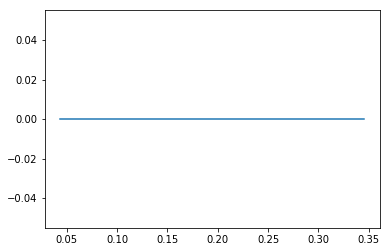

In [57]:
plt.plot(x, y)

In [58]:
from scipy import stats

In [59]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [60]:
intercept

0.0

In [61]:
slope, intercept, r_value, p_value, std_err

(0.0, 0.0, 0.0, 1.0, 0.0)

In [62]:
x, y

(array([0.04322727, 0.1654347 , 0.3454915 ]), [0, 0, 0])

In [66]:
recta0 = intercept + slope*0
recta1 = intercept + slope*0.3454915

hv.Curve([(recta0, 0), (recta1, 0.3454915)])


:Curve   [x]   (y)

In [64]:
hv.Curve(kdims = (x), vdims = (y))
0.04322727, 0.1654347 , 0.3454915 ]

SyntaxError: invalid syntax (<ipython-input-64-7897f175f667>, line 2)

In [68]:
points = [(0, 0.04322727), (0, 0.1654347), (0, 0.3454915)]
plot = hv.Curve(points).opts(invert_axes = True).opts(color = "black") * hv.Curve([(recta0, 0), (recta1, 0.3454915)])
plot *= hv.Scatter(points).opts(size = 10)
plot.opts(padding = 0.1)

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Curve.II  :Curve   [x]   (y)
   .Scatter.I :Scatter   [x]   (y)

In [56]:
polygon_dataframe["iline"].min()


numpy.int64

In [53]:
from scipy import stats

In [ ]:
stats.linregress(sins, amplitude_list)